In [1]:
import numpy as np
import mosek
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [2]:
def disc_linear_system(A, B, delta_t):
    '''
    Discrete a linear system with implicit Euler
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]
    Returns:
        Ak
        Bk
    '''
    Nx = np.shape(A)[0]
    Ix = np.identity(Nx)

    Ak = np.linalg.inv(Ix - delta_t * A)
    Bk = np.linalg.inv(Ix - delta_t * A) @ (delta_t * B)

    
    def disc_linear_fn(x, u):
        x_next = Ak @ x + Bk @ u
        
        return x_next
    
    
    return disc_linear_fn

In [3]:
def disc_linear_system(A, B, delta_t):
    '''
    Discrete a linear system with implicit Euler
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]
    Returns:
        Ak
        Bk
    '''
    Nx = np.shape(A)[0]
    Ix = np.identity(Nx)

    Ak = expm(A*delta_t)
    Bk = (expm(A * delta_t) - Ix) @ np.linalg.inv(A) @ B

    
    def disc_linear_fn(x, u):
        x_next = Ak @ x + Bk @ u
        
        return x_next
    
    
    return disc_linear_fn




In [4]:
# Collect data as initial condition
def data_generation(sys, nx, nu, N, state_init = None, input_seq = None):
    # N is the length of collected data
    # Modify this for measurement functions (y = Cx)
    if input_seq is None:
        input_seq = np.random.uniform(-1,1,(nu, N))
#         input_seq = np.random.rand(nu, N)  
    N_it = np.shape(input_seq)[1] # Number of iteration
    if state_init is None:
        state_init = np.random.rand(nx,1) 
    state_seq = state_init
    xk = state_init
    for _ in range(N_it):
        uk = input_seq[:,[_]]
        state_next = sys(xk, uk)
        state_seq = np.concatenate((state_seq, state_next),axis=1)
        xk = state_next
    # Remark: the length of state_seq is larger than the input_seq by one.
    return state_seq, input_seq

In [5]:
# Construct Hankel matrix
def Hankel(sequence, L):
    n, T = np.shape(sequence)
    print(n,T)
    Hankel_matrix = np.empty((n * L, 0), dtype = float)
    for _ in range(T-L+1):
        Hankel_matrix = np.concatenate((Hankel_matrix, sequence[: , _ : _+L ].reshape(-1,1, order = 'F')),axis = 1)
    return Hankel_matrix

In [6]:
# Formulate optimization problem
def define_opt(nu, ny, Q, R, U_Hankel, Y_Hankel, T, L, n, u_ns, y_ns, r = None, uub = None, ulb = None, yub = None, ylb = None):
    # Let the reference traj r be a list setpoint for input and output. To be modified, if tracking traj required.
    
    u_decision = cp.Variable(((L+n)*nu,1))
    y_decision = cp.Variable(((L+n)*ny,1))
    
    
    alpha = cp.Variable((T-(L+n)+1,1))
    
    u_init_para = cp.Parameter((n * nu, 1))
    y_init_para = cp.Parameter((n * ny, 1))
    
    
    loss_func = 0
    for _ in range(L):
        loss_func += cp.quad_form(y_decision[ ( n + _ ) * ny : ( n + _ + 1 ) * ny ,:] - np.array(r[:ny]).reshape(-1,1), Q)
        loss_func += cp.quad_form(u_decision[ ( n + _ ) * nu : ( n + _ + 1 ) * nu ,:] - np.array(r[ny:]).reshape(-1,1), R)

    obj = cp.Minimize(loss_func)
    # Define constraints
    constraint = []
    
    constraint += [ u_decision == U_Hankel @ alpha ]
    constraint += [ y_decision == Y_Hankel @ alpha ]
    constraint += [ u_decision[: n * nu] == u_init_para ]
    constraint += [ y_decision[: n * ny] == y_init_para ]
    constraint += [ u_decision[- n * nu :] == u_ns ]
    constraint += [ y_decision[- n * ny :] == y_ns ]
    
    if uub is not None:
        for _ in range(L):
            constraint += [u_decision[ ( n + _ ) * nu : ( n + _ + 1 ) * nu, : ] <= uub]
    
    if ulb is not None:
        for _ in range(L):
            constraint += [u_decision[ ( n + _ ) * nu : ( n + _ + 1 ) * nu, : ] >= ulb]

    if yub is not None:
        for _ in range(L):
            constraint += [y_decision[ ( n + _ ) * ny : ( n + _ + 1 ) * ny ,:] <= yub]
            
    if ylb is not None:
        for _ in range(L):
            constraint += [y_decision[ ( n + _ ) * ny : ( n + _ + 1 ) * ny ,:] >= ylb]
            
    prob = cp.Problem(obj,constraint)
    
    return prob, alpha, u_init_para, y_init_para, u_decision, y_decision

In [7]:
# Simulation
def sim(opt_prob, sys, C, N_sim, delta_t, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel, r = None):
    # Generally, u_init and y_init are sequences, and x_init is the corresponding initial state of the last element in sequences
    t0 = 0
    xk = x_init
    uk = 0
    t = t0
    h = delta_t

    x_list = []
    x_list += xk.flatten().tolist()
    u_list = []

    # N_sample_max
    for i in range(N_sim):
        u_init_para.value = u_init
        y_init_para.value = y_init
        prob.solve(solver=cp.MOSEK)
#         uk = (input_Hankel @ alpha.value)[nu * n : nu * (n+1),:]
#         print("u dec",u_decision.value)
#         print("y dec",y_decision.value)
        uk = u_decision.value[nu * n : nu * (n+1),:]
        print(uk,xk)
        u_list += uk.flatten().tolist()
        x_kp1 = sys(xk, uk)
        xk = x_kp1
        yk = C @ xk
        u_init = np.concatenate(( u_init[nu:,:], uk ), axis = 0 )
        y_init = np.concatenate(( y_init[ny:,:], yk ), axis = 0 )
        x_list += xk.flatten().tolist()

    return x_list, u_list

### First case study, Mass spring system 

case 1: full state observation

1. larger prediction horizon required than DeePC; otherwise not stable.
2. Higher cost, since terminal constraints imposed.
3. Both methods fails with random input and output sequences in small value -> multiply 10

In [8]:
m = 2  # [kg]
k1 = 3  # [N/m]
k2 = 2  # [N/m]

A = np.array([[0, 1], [-k2 / m, -k1 / m]])
B = np.array([[0], [1 / m]])


Q = np.diag([10, 1])
R = np.diag([1])


dt = 0.1
disc_sys_fn = disc_linear_system(A,B, dt)
nx = 2
nu = 1


n = 1
L = 15
T = (nu + 1) * (n + L + nx) - 1
T = 200
state_seq, input_seq = data_generation(disc_sys_fn, nx, nu, T)

state_init = np.array([[5],[0]])
y_init_seq, u_init_seq = data_generation(disc_sys_fn, nx, nu, n, state_init = state_init)

In [9]:
state_Hankel = Hankel(state_seq[:,:-1], L+n)
input_Hankel = Hankel(input_seq, L+n)

2 200
1 200


In [10]:
y_init = y_init_seq[:,:-1].reshape(-1,1, order = 'F')
u_init = u_init_seq.reshape(-1,1, order = 'F')

u_ns = np.array([[0]])  # terminal equalibrium constraints
y_ns = np.array([[0],[0]])

In [11]:
r = [0,0,0]

In [12]:
prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, nx, Q, R, input_Hankel, state_Hankel, T, L, n, u_ns, y_ns, r = r)

In [13]:
u_init

array([[0.22454457]])

In [14]:
y_init

array([[5.],
       [0.]])

In [15]:
u_init_para.value = u_init
# u_init_para.value = np.array([[6.19632452]])
y_init_para.value = y_init
prob.solve(solver=cp.MOSEK,verbose=True)
input_Hankel @ alpha.value 



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 263             
  Cones                  : 30              
  Scalar variables       : 159             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 263             
  Cones                  : 30              
  Scalar variables       : 159             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 78
Optimizer  - Cones                  : 31
Optimizer  - Scalar variables

array([[ 2.24544665e-01],
       [-2.24886257e+01],
       [-2.09963189e+01],
       [-1.93535113e+01],
       [-1.75231583e+01],
       [-1.54606350e+01],
       [-1.31140029e+01],
       [-1.04244907e+01],
       [-7.32707239e+00],
       [-3.75106534e+00],
       [ 3.79138917e-01],
       [ 5.14318464e+00],
       [ 1.06236928e+01],
       [ 1.69050173e+01],
       [ 2.40717971e+01],
       [ 4.23512307e-09]])

In [16]:
state_Hankel @ alpha.value 

array([[ 5.00000004e+00],
       [-4.36186403e-08],
       [ 4.97675803e+00],
       [-4.53125219e-01],
       [ 4.85761623e+00],
       [-1.89176111e+00],
       [ 4.60921786e+00],
       [-3.04328054e+00],
       [ 4.25915299e+00],
       [-3.93001607e+00],
       [ 3.83289824e+00],
       [-4.57192913e+00],
       [ 3.35406457e+00],
       [-4.98640376e+00],
       [ 2.84466260e+00],
       [-5.18810523e+00],
       [ 2.32537838e+00],
       [-5.18890606e+00],
       [ 1.81585360e+00],
       [-4.99787484e+00],
       [ 1.33496385e+00],
       [-4.62132052e+00],
       [ 9.01089850e-01],
       [-4.06288991e+00],
       [ 5.32376205e-01],
       [-3.32371759e+00],
       [ 2.46972487e-01],
       [-2.40262733e+00],
       [ 6.32515687e-02],
       [-1.29638458e+00],
       [ 5.81121115e-08],
       [ 7.25517258e-08]])

In [17]:
C = np.identity(nx)
N_sim = 100
ny = nx
# x_init = y_init[-(nx):,:]
x_init = y_init_seq[:,[-1]]

In [18]:
x_init

array([[ 4.97675799],
       [-0.45312518]])

In [19]:
x_list, u_list = sim(prob, disc_sys_fn, C, N_sim, dt, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel)

[[-22.48862574]] [[ 4.97675799]
 [-0.45312518]]
[[-12.62459041]] [[ 4.8576162 ]
 [-1.89176107]]
[[-10.77423066]] [[ 4.62912235]
 [-2.65522278]]
[[-8.07061708]] [[ 4.33533639]
 [-3.20193375]]
[[-6.00905495]] [[ 3.99869174]
 [-3.51746185]]
[[-4.27212245]] [[ 3.63929786]
 [-3.66084265]]
[[-2.86200752]] [[ 3.27245031]
 [-3.66977222]]
[[-1.72803293]] [[ 2.90987203]
 [-3.57804479]]
[[-0.83245421]] [[ 2.56021775]
 [-3.41333219]]
[[-0.13927813]] [[ 2.22962541]
 [-3.1983794 ]]
[[0.38366855]] [[ 1.92218075]
 [-2.95156093]]
[[0.76507826]] [[ 1.64032313]
 [-2.68749619]]
[[1.0302397]] [[ 1.3851932 ]
 [-2.41759828]]
[[1.2012128]] [[ 1.15692825]
 [-2.15057242]]
[[1.29704994]] [[ 0.95491034]
 [-1.89286209]]
[[1.33403432]] [[ 0.7779724 ]
 [-1.64904364]]
[[1.32594743]] [[ 0.62456737]
 [-1.42217231]]
[[1.2843175]] [[ 0.49290507]
 [-1.21408172]]
[[1.21865427]] [[ 0.38106127]
 [-1.02564143]]
[[1.13680126]] [[ 0.28706287]
 [-0.85697678]]
[[1.04498469]] [[ 0.20895317]
 [-0.70764855]]
[[0.94818053]] [[ 0.1448

In [20]:
x_init

array([[ 4.97675799],
       [-0.45312518]])

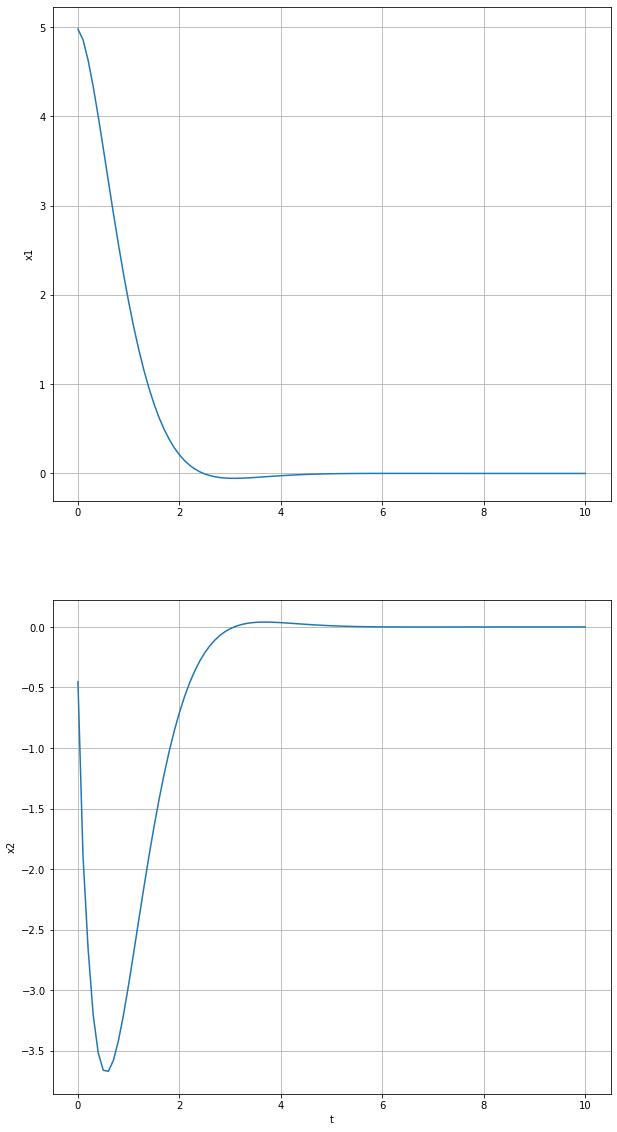

In [21]:
delta_t = dt
n = nx

x_traj = x_list

Nt = np.shape(x_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    x_traj_temp = x_traj[i::n]
    plt.plot(t_plot, x_traj_temp)
    plt.ylabel('x' + str(i + 1))

plt.xlabel('t')
plt.show()

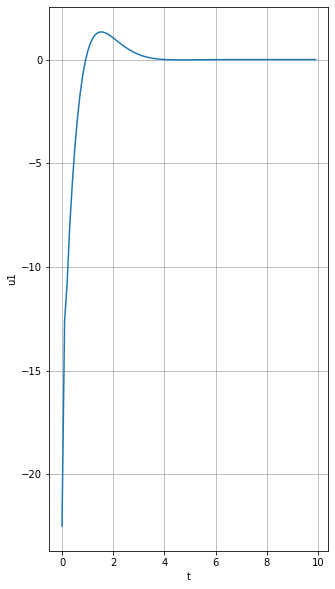

In [22]:
delta_t = dt
n = nu

u_traj = u_list

Nt = np.shape(u_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(5, 10))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    u_traj_temp = u_traj[i::n]
    plt.plot(t_plot, u_traj_temp)
    plt.ylabel('u' + str(i + 1))

plt.xlabel('t')
plt.show()

Case 2: Only observe the position of the mass

1. Set $u^s = 1$ and $y^s = 0$, the simulated stable state is [1.06351793, 0.53228785] and input [0.00174959]

In [23]:
m = 2  # [kg]
k1 = 3  # [N/m]
k2 = 2  # [N/m]

A = np.array([[0, 1], [-k2 / m, -k1 / m]])
B = np.array([[0], [1 / m]])
C = np.array([[1,0]])

Q = np.diag([10])
R = np.diag([1])


dt = 0.1
disc_sys_fn = disc_linear_system(A,B, dt)
nx = 2
ny = 1
nu = 1


n = 1
L = 15
T = (nu + 1) * (n + L + nx) - 1
T = 200
state_seq, input_seq = data_generation(disc_sys_fn, nx, nu, T)
output_seq = C @ state_seq

input_Hankel = Hankel(input_seq, L+n)
state_Hankel = Hankel(state_seq[:,:-1], L+n)
output_Hankel = Hankel(output_seq[:,:-1], L+n)



state_init = np.array([[5],[0]])
x_init_seq, u_init_seq = data_generation(disc_sys_fn, nx, nu, n, state_init = state_init)
y_init_seq = C @ x_init_seq


y_init = y_init_seq[:,:-1].reshape(-1,1, order = 'F')
u_init = u_init_seq.reshape(-1,1, order = 'F')

u_ns = np.array([[0]])  # terminal equalibrium constraints
# u_ns = np.array([[1]])
y_ns = np.array([[0]])

r = [0,0]
# r = [0,1]
prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, T, L, n, u_ns, y_ns, r = r)
u_init
y_init

1 200
2 200
1 200


array([[5.]])

In [24]:
u_init_para.value = u_init
# u_init_para.value = np.array([[6.19632452]])
y_init_para.value = y_init
prob.solve(solver=cp.MOSEK,verbose=True)
input_Hankel @ alpha.value 



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 247             
  Cones                  : 30              
  Scalar variables       : 126             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 247             
  Cones                  : 30              
  Scalar variables       : 126             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 62
Optimizer  - Cones                  : 31
Optimizer  - Scalar variables

array([[-1.66854932e-01],
       [ 1.01881059e+00],
       [ 1.56458198e+00],
       [ 1.99788400e+00],
       [ 2.32490760e+00],
       [ 2.55088569e+00],
       [ 2.68000382e+00],
       [ 2.71531060e+00],
       [ 2.65868920e+00],
       [ 2.51085241e+00],
       [ 2.27135385e+00],
       [ 1.93864998e+00],
       [ 1.51017959e+00],
       [ 9.82470183e-01],
       [ 3.51281313e-01],
       [-5.41382092e-10]])

In [25]:
N_sim = 100
# x_init = y_init[-(nx):,:]
x_init = x_init_seq[:,[-1]]

In [26]:
x_init

array([[ 4.97582741],
       [-0.47126786]])

In [27]:
x_list, u_list = sim(prob, disc_sys_fn, C, N_sim, dt, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel)

[[1.01881059]] [[ 4.97582741]
 [-0.47126786]]
[[1.00002219]] [[ 4.91089909]
 [-0.81755968]]
[[0.98031643]] [[ 4.81413127]
 [-1.10890107]]
[[0.95519217]] [[ 4.69076744]
 [-1.35028553]]
[[0.9256202]] [[ 4.54555253]
 [-1.54668315]]
[[0.89246736]] [[ 4.38275045]
 [-1.70274417]]
[[0.85650685]] [[ 4.2061758 ]
 [-1.82280513]]
[[0.8184352]] [[ 4.01922484]
 [-1.91089673]]
[[0.7788815]] [[ 3.82490566]
 [-1.97075256]]
[[0.73834881]] [[ 3.62586742]
 [-2.00581895]]
[[0.69732813]] [[ 3.42442839]
 [-2.01926891]]
[[0.6562275]] [[ 3.2226028 ]
 [-2.01401126]]
[[0.61539992]] [[ 3.02212662]
 [-1.9927043 ]]
[[0.57515264]] [[ 2.82448197]
 [-1.95776861]]
[[0.5357345]] [[ 2.63092024]
 [-1.91139982]]
[[0.49736047]] [[ 2.44248391]
 [-1.85558226]]
[[0.46020295]] [[ 2.26002705]
 [-1.79210157]]
[[0.42442479]] [[ 2.08423455]
 [-1.72255777]]
[[0.39007408]] [[ 1.91564008]
 [-1.64837672]]
[[0.35729125]] [[ 1.75464272]
 [-1.57082647]]
[[0.32611164]] [[ 1.60152241]
 [-1.49102318]]
[[0.2965712]] [[ 1.45645439]
 [-1.40994

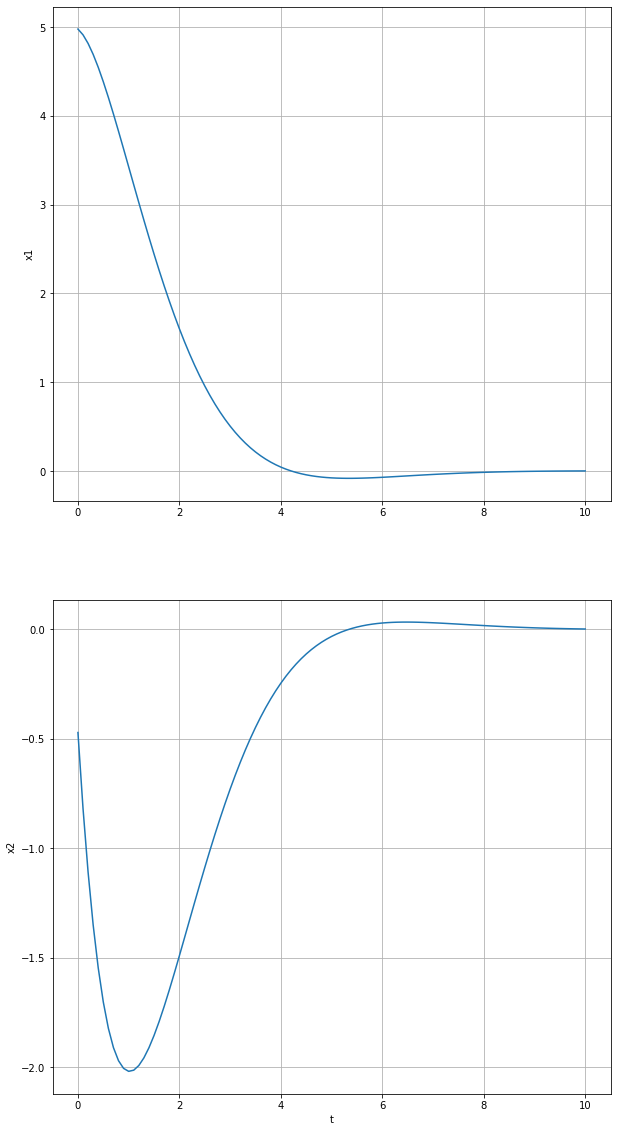

In [28]:
delta_t = dt
n = nx

x_traj = x_list

Nt = np.shape(x_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    x_traj_temp = x_traj[i::n]
    plt.plot(t_plot, x_traj_temp)
    plt.ylabel('x' + str(i + 1))

plt.xlabel('t')
plt.show()

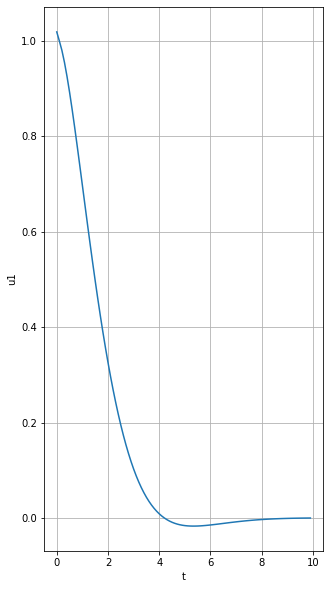

In [29]:
delta_t = dt
n = nu

u_traj = u_list

Nt = np.shape(u_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(5, 10))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    u_traj_temp = u_traj[i::n]
    plt.plot(t_plot, u_traj_temp)
    plt.ylabel('u' + str(i + 1))

plt.xlabel('t')
plt.show()

### Second case study: four tank system (case study in their paper)

It is the linear version of the nonlinear four tank system (ref: Nonlinear Model Predictive Control of a Four Tank System: An Experimental Stability Study).

$\begin{aligned} \dot{x}_{1} &=-\frac{a_{1}}{A_{1}} \sqrt{2 g x_{1}}+\frac{a_{3}}{A_{1}} \sqrt{2 g x_{3}}+\frac{\gamma_{1}}{A_{1}} u_{1} \\ \dot{x}_{2} &=-\frac{a_{2}}{A_{2}} \sqrt{2 g x_{2}}+\frac{a_{4}}{A_{2}} \sqrt{2 g x_{4}}+\frac{\gamma_{2}}{A_{2}} u_{2} \\ \dot{x}_{3} &=-\frac{a_{3}}{A_{3}} \sqrt{2 g x_{3}}+\frac{\left(1-\gamma_{2}\right)}{A_{3}} u_{2} \\ \dot{x}_{4} &=-\frac{a_{4}}{A_{4}} \sqrt{2 g x_{4}}+\frac{\left(1-\gamma_{1}\right)}{A_{4}} u_{1} \end{aligned}$

Linearized version (ref: Data-Driven Model Predictive Control with Stability and Robustness Guarantees)

$ x_{k+1} =\left[\begin{array}{cccc}0.921 & 0 & 0.041 & 0 \\ 0 & 0.918 & 0 & 0.033 \\ 0 & 0 & 0.924 & 0 \\ 0 & 0 & 0 & 0.937\end{array}\right] x_{k} +\left[\begin{array}{cc}0.017 & 0.001 \\ 0.001 & 0.023 \\ 0 & 0.061 \\ 0.072 & 0\end{array}\right] u_{k}$

$y_{k}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\end{array}\right] x_{k}$

set point: $\left(u^{s}, y^{s}\right)=\left(\left[\begin{array}{l}1 \\ 1\end{array}\right],\left[\begin{array}{l}0.65 \\ 0.77\end{array}\right]\right)$

1. Why simulation not stable?

In [30]:
def disc_four_tank(x, u):
    A = np.array([[0.921,  0, 0.041, 0], [0, 0.918, 0, 0.033], [0, 0, 0.924, 0], [0, 0, 0, 0.937]])
    B = np.array([[0.017, 0.001], [0.001, 0.023], [0, 0.061], [0.072, 0]])
    x_next = A@x + B@u

    return x_next

In [48]:
A = np.array([[0.921,  0, 0.041, 0], [0, 0.918, 0, 0.033], [0, 0, 0.924, 0], [0, 0, 0, 0.937]])
B = np.array([[0.017, 0.001], [0.001, 0.023], [0, 0.061], [0.072, 0]])
C = np.array([[1,0,0,0],[0,1,0,0]])




# disc_sys_fn = disc_linear_fn
nx = 4
nu = 2
ny = 2

Q = np.diag([3] * ny)
R = np.diag([1e-4] * nu)



n = 1
L = 30
# T = (nu + 1) * (n + L + nx) - 1
T = 400

u_ns = np.array([[1,1]* n]).reshape(-1,1)  # terminal equalibrium constraints
y_ns = np.array([[0.65,0.77]*n]).reshape(-1,1)

state_init = np.array([[0.1],[0.1],[0.2],[0.2]])

# state_seq, input_seq = data_generation(disc_four_tank, nx, nu, T, state_init = state_init)
state_seq, input_seq = data_generation(disc_four_tank, nx, nu, T)

output_seq = C @ state_seq

In [49]:
state_seq

array([[ 0.97957173,  0.94722666,  0.9120512 , ...,  0.05900821,
         0.05098052,  0.04107972],
       [ 0.43941332,  0.42580359,  0.43763322, ...,  0.0308432 ,
         0.03324768,  0.05290494],
       [ 0.78530366,  0.70659813,  0.69882597, ..., -0.04026467,
        -0.04057276,  0.00760415],
       [ 0.87335492,  0.87405093,  0.86105058, ...,  0.19094695,
         0.17188684,  0.1400971 ]])

In [50]:
state_Hankel = Hankel(state_seq[:,:-1], L+n)
output_Hankel = Hankel(output_seq[:,:-1], L+n)
input_Hankel = Hankel(input_seq, L+n)

4 400
2 400
2 400


In [51]:
x_init_seq, u_init_seq = data_generation(disc_four_tank, nx, nu, n, state_init = state_init)

In [52]:
x_init_seq

array([[0.1       , 0.0980411 ],
       [0.1       , 0.10980762],
       [0.2       , 0.21548588],
       [0.2       , 0.17570232]])

In [53]:
y_init_seq = C @ x_init_seq
y_init_seq

array([[0.1       , 0.0980411 ],
       [0.1       , 0.10980762]])

In [54]:
y_init = y_init_seq[:,:-1].reshape(-1,1, order = 'F')
# x_init = x_init_seq[:,:-1].reshape(-1,1, order = 'F')
x_init = x_init_seq[:,-1].reshape(-1,1, order = 'F')
u_init = u_init_seq.reshape(-1,1, order = 'F')
x_init

array([[0.0980411 ],
       [0.10980762],
       [0.21548588],
       [0.17570232]])

In [55]:
y_init

array([[0.1],
       [0.1]])

In [56]:
u_init

array([[-0.16246772],
       [ 0.50304721]])

In [57]:
r = [0.65,0.77,1,1]

In [58]:
prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, T, L, n, u_ns, y_ns, r = r)

In [59]:
u_init_para.value = u_init
# u_init_para.value = np.array([[6.19632452]])
y_init_para.value = y_init
prob.solve(solver=cp.MOSEK,verbose=True)
# input_Hankel @ alpha.value 
# state_Hankel @ alpha.value 



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 554             
  Cones                  : 60              
  Scalar variables       : 372             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 554             
  Cones                  : 60              
  Scalar variables       : 372             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 184
Optimizer  - Cones                  : 61
Optimizer  - Scalar variable

0.3154208184583942

In [60]:
# output_Hankel @ alpha.value 

In [61]:
# u_decision.value

In [62]:
# y_decision.value

In [63]:
# state_Hankel @ alpha.value 

In [64]:
N_sim = 100
x_list, u_list = sim(prob, disc_four_tank, C, N_sim, dt, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel)

[[-18.41461299]
 [-12.98545958]] [[0.0980411 ]
 [0.10980762]
 [0.21548588]
 [0.17570232]]
[[-35.70712095]
 [-28.67260711]] [[-0.22690311]
 [-0.21047861]
 [-0.59300408]
 [-1.16121906]]
[[-66.49347557]
 [-51.49985212]] [[-0.86898459]
 [-0.92671668]
 [-2.29696481]
 [-3.65897496]]
[[-117.7526456]
 [ -94.0131671]] [[-2.07639931]
 [-2.22246216]
 [-5.26388646]
 [-8.21598978]]
[[-212.78294382]
 [-167.88708085]] [[ -4.22399125]
 [ -4.59140342]
 [-10.59863428]
 [-16.17657291]]
[[-380.50401165]
 [-302.8823224 ]] [[ -8.11003707]
 [ -8.82292104]
 [-20.03425001]
 [-30.47782077]]
[[-684.91714187]
 [-543.2079429 ]] [[-15.06219891]
 [-16.45200703]
 [-36.98746867]
 [-55.9540069 ]]
[[-1226.66655853]
 [ -975.51191548]] [[ -27.57557077]
 [ -30.12812451]
 [ -67.31210557]
 [-101.74293868]]
[[-2204.72192562]
 [-1751.21412338]] [[ -49.98574042]
 [ -54.67857589]
 [-121.70261239]
 [-183.65312576]]


ValueError: Cannot unpack invalid solution: Solution(status=UNKNOWN, opt_val=nan, primal_vars={}, dual_vars={}, attr={'solve_time': 0.09477496147155762})

In [ ]:
b =  B @ np.array([[1],[1]])
a = np.linalg.inv(np.identity(4) - A)

np.linalg.solve(a, b)